In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

from character_models.mlp import *

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
torch.set_default_device(device)
print(device)

cuda


In [3]:
from typing import Any


class Linear:
    def __init__(self, n_in: int, n_out: int, bias: bool = True) -> None:
        """
        Inputs:
            n_in: number of inputs to the layer
            n_out: number of outputs of the layer
            bias: boolean to init bias or not
                No bias will use batchnormalisation
                typically no bias is used with batchnorm as batchnorm will remove the effect of bias in the normalisation step.
        """

        # n_in**0.5 is the kaiming normalisation factor
        self.weight = torch.randn((n_in, n_out)) / n_in**0.5
        self.bias = torch.zeros(n_out) if bias else None

    def __call__(self, x) -> Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        """
        Inputs:
            dim: dimension for gamma and beta
            eps: epsilon. Added to the denominator for numerical stability during BatchNorm
            momentum: value used for running mean and var
        """
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Trainable Parameters used to scale and shift the batchnorm output
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Running mean and var known as buffers in PyTorch
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> Any:
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            # During inference use the running mean and running var
            xmean = self.running_mean
            xvar = self.running_var

        # Normalise to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Just for statistics
        self.out = self.gamma * xhat + self.beta

        with torch.no_grad():
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * xmean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x) -> Any:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [4]:
words = open("names.txt", "r").read().splitlines()

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

In [6]:
vocab_size = len(stoi)
word_count = len(words)
print(f"{vocab_size=}")
print(f"{word_count=}")

vocab_size=27
word_count=32033


In [7]:
block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [8]:
n_embed = 15  # Dimensionality of the character embedding vector
n_hidden = 100  # Number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embed))
layers = [
    Linear(n_embed * block_size, n_hidden),  # Input Layer
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # Make Last layer less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # other layerrs apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Uses 5/3 as a gain to slighty counteract the "squashing" function Tanh()
            # so values dont get set to 1 and saturated and reduce effect of backprop
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

49186


In [9]:
max_steps = 200000
batch_size = 32
lossi = []
best_loss = 0
update_to_data = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward
    emb = C[Xb]
    out = emb.view(emb.shape[0], -1)

    for layer in layers:
        out = layer(out)
    loss = F.cross_entropy(out, Yb)

    # backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")

    with torch.no_grad():
        # comparing the std of the update to the parameters to the std of the data of the parameter
        update_to_data.append(
            [(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]
        )

    lossi.append(loss.log10().item())

      0/ 200000: 3.283747
  10000/ 200000: 1.793268
  20000/ 200000: 2.226735
  30000/ 200000: 1.992843
  40000/ 200000: 2.622980
  50000/ 200000: 1.967206
  60000/ 200000: 2.121900
  70000/ 200000: 1.764708
  80000/ 200000: 2.222298
  90000/ 200000: 2.327348
 100000/ 200000: 2.110261
 110000/ 200000: 1.882924
 120000/ 200000: 2.493693
 130000/ 200000: 2.051689
 140000/ 200000: 1.960874
 150000/ 200000: 2.000465
 160000/ 200000: 1.570713
 170000/ 200000: 2.043294
 180000/ 200000: 1.817554
 190000/ 200000: 2.197507


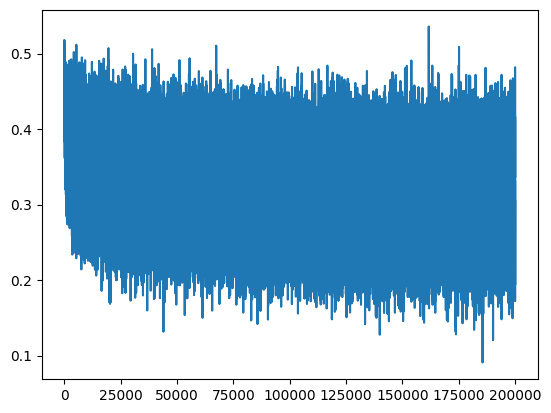

In [14]:
plt.plot(range(max_steps), lossi)

weight   (27, 15) | mean: -0.000000 | std 1.286055e-02 | grad:data ratio 1.192954e-02
weight  (45, 100) | mean: -0.000028 | std 8.507667e-03 | grad:data ratio 2.408798e-02
weight (100, 100) | mean: +0.000004 | std 6.626520e-03 | grad:data ratio 2.680153e-02
weight (100, 100) | mean: -0.000105 | std 6.594178e-03 | grad:data ratio 2.744521e-02
weight (100, 100) | mean: +0.000031 | std 6.304376e-03 | grad:data ratio 2.708809e-02
weight (100, 100) | mean: +0.000012 | std 5.862564e-03 | grad:data ratio 2.601601e-02
weight  (100, 27) | mean: +0.000091 | std 9.419880e-03 | grad:data ratio 2.870399e-02


Text(0.5, 1.0, 'weights gradient distribution')

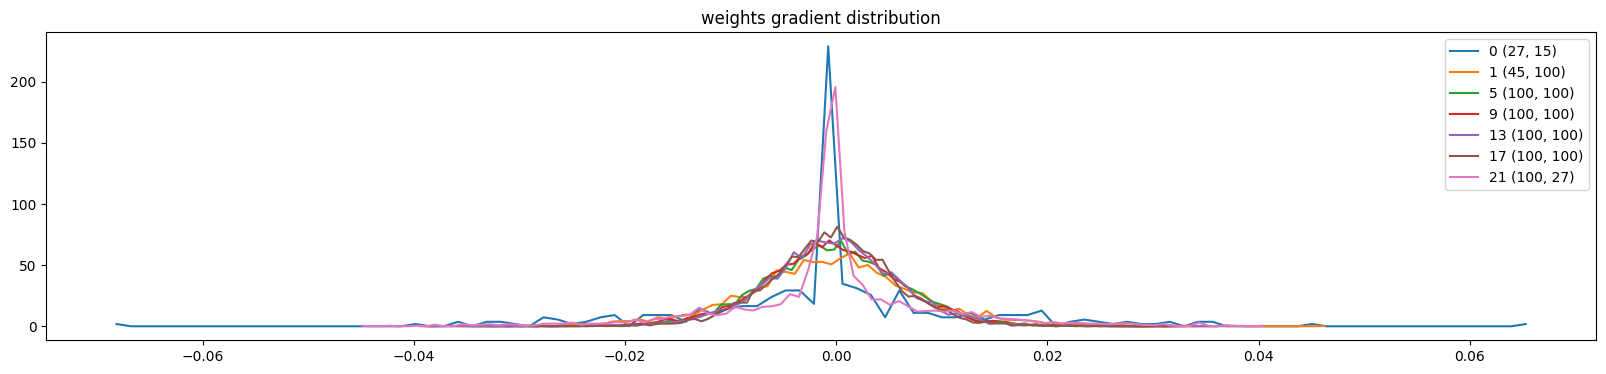

In [15]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean: %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

# NO BATCHNORM
# weight   (27, 10) | mean: -0.000044 | std 1.408688e-03 | grad:data ratio 1.417127e-03
# weight  (30, 100) | mean: +0.000016 | std 1.289131e-03 | grad:data ratio 4.237266e-03
# weight (100, 100) | mean: +0.000002 | std 1.077378e-03 | grad:data ratio 6.542478e-03
# weight (100, 100) | mean: -0.000001 | std 9.551119e-04 | grad:data ratio 5.759782e-03
# weight (100, 100) | mean: +0.000001 | std 8.681275e-04 | grad:data ratio 5.148292e-03
# weight (100, 100) | mean: +0.000001 | std 7.712888e-04 | grad:data ratio 4.597571e-03
# weight  (100, 27) | mean: +0.000000 | std 2.302213e-02 | grad:data ratio 2.232750e+00

# Result above:
# Last layer has 10x larger std than previous layers therefore trains faster than the other layers
# Fixes itself as you train longer


# With BatchNorm at every layer
# weight   (27, 10) | mean: +0.000000 | std 1.066665e-02 | grad:data ratio 1.055156e-02
# weight  (30, 100) | mean: +0.000068 | std 9.517120e-03 | grad:data ratio 3.137178e-02
# weight (100, 100) | mean: +0.000117 | std 8.259309e-03 | grad:data ratio 5.015843e-02
# weight (100, 100) | mean: +0.000039 | std 6.621391e-03 | grad:data ratio 3.926402e-02
# weight (100, 100) | mean: +0.000083 | std 6.303600e-03 | grad:data ratio 3.836602e-02
# weight (100, 100) | mean: -0.000018 | std 5.940982e-03 | grad:data ratio 3.550854e-02
# weight  (100, 27) | mean: -0.000105 | std 1.082340e-02 | grad:data ratio 6.410874e-02

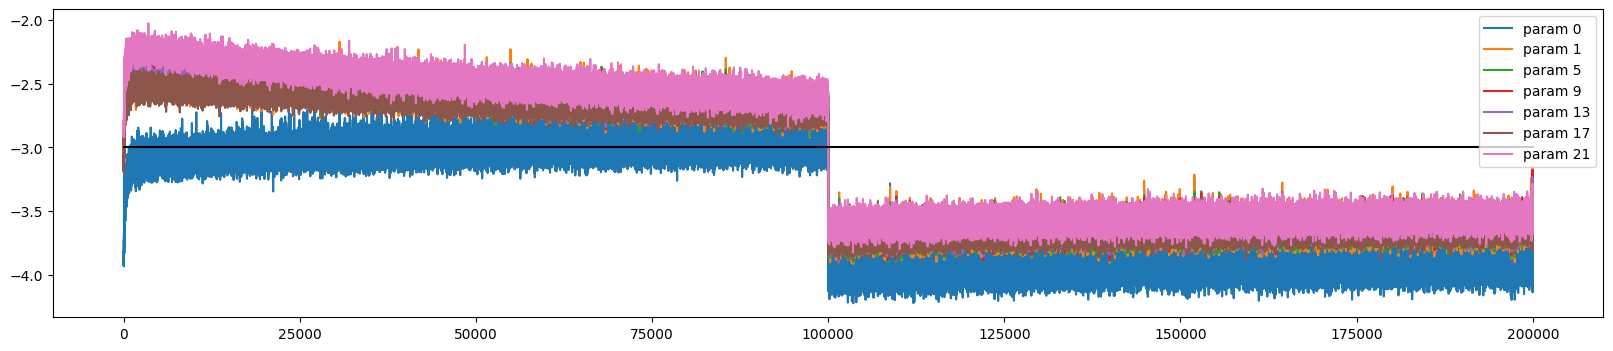

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:  # Only weights
        plt.plot([update_to_data[j][i] for j in range(len(update_to_data))])
        legends.append("param %d" % i)
plt.plot([0, len(update_to_data)], [-3, -3], "k")
plt.legend(legends);

# PLot shows that the ratio of the update the actual values in the tensor that is being updated which is roughly ~1e-3
# if below 1e-3 ratio then it learns very slow

In [18]:
@torch.no_grad()  # Decorator disables gradient tracking
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "test": (Xte, Yte), "val": (Xdev, Ydev)}[split]
    emb = C[x]
    out = emb.view(emb.shape[0], -1)

    for layer in layers:
        layer.training = False
    for layer in layers:
        out = layer(out)

    loss = F.cross_entropy(out, y)
    print(split, loss.item())


split_loss("train")
split_loss("test")
split_loss("val")

train 2.0059237480163574
test 2.0806124210357666
val 2.082921028137207


In [24]:
for _ in range(20):
    names = []
    context = [0] * block_size
    while True:
        # Forward pass
        emb = C[torch.tensor([context])]
        out = emb.view(emb.shape[0], -1)

        for layer in layers:
            layer.training = False

        for layer in layers:
            out = layer(out)

        probs = F.softmax(out, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        names.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in names))

sadaine.
moas.
kayze.
rayansh.
eryn.
hazeminalien.
jazlyn.
col.
aqui.
jian.
faijahi.
kydni.
zelwidmariyah.
panton.
rilee.
viralymarturine.
mariel.
bashi.
khab.
deveri.
